Data Science Project: Planning Stage
DSCI 100
kelsey Xian
Nov.12.2025

Question 3: We are interested in demand forecasting, namely, what time windows are most likely to have large number of simultaneous players. This is because we need to ensure that the number of licenses on hand is sufficiently large to accommodate all parallel players with high probability. 

(1) Data Description:

In [1]:
library(tidyverse)
library(lubridate)
library(janitor)
library(skimr)
library(kableExtra)

players <- read_csv("players.csv") |> clean_names()
sessions <- read_csv("sessions.csv") |> clean_names()

glimpse(players)
glimpse(sessions)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test




ERROR: Error in library(skimr): there is no package called ‘skimr’


The project uses two datasets, players.csv and sessions.csv, which I loaded into R using read_csv() and inspected with glimpse() and skim(). The players.csv file contains 196 observations and 7 variables describing each unique player, including age, gender, experience level, total played hours, newsletter subscription status, and a hashed email identifier used to join the tables. All variables were imported cleanly, although the age column contains two missing values and categories such as experience and gender appear self-reported and may include inconsistencies. The played_hours variable shows meaningful variation and may contain outliers because some players spend much more time on the server than others. The second dataset, sessions.csv, contains 1535 observations and 5 variables, recording the start and end time of each play session. The timestamps in this file are stored as text in the format “dd/mm/yyyy hh:mm”, so they must be converted to proper datetime objects. The dataset also includes numeric Unix-epoch timestamps (original_start_time, original_end_time), which appear redundant but confirm that the session times were originally collected automatically by the server. A potential issue is that no timezone information is included, and some sessions are very short, which may indicate brief log-ins or recording artifacts. Both datasets appear complete and consistent overall, with no duplicated hashed emails in players.csv, and they provide the necessary structure to explore how player characteristics relate to newsletter subscription behavior. The summary statistics generated below report variable types, missing values, and numerical summaries rounded to two decimals, as required.

(2) Questions:

Broad Question

Question 1:
“What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter?”

Specific Question

“Can player characteristics—such as age, gender, experience level, and total played hours—predict whether a player subscribes to the newsletter in this dataset?”

How the data support this question

The players.csv dataset contains a clear binary response variable, subscribe, which indicates whether each player opted into the newsletter. It also includes several potential 
explanatory variables, such as age, gender, experience, and played_hours, all of which may help explain subscription behaviour. These variables are already stored at the player level, 
so no major wrangling is required. If needed, data from sessions.csv can be merged later using the hashed_email key to create additional behavioural features (e.g., session count), 
but such processing is optional for defining the core predictive question.

(3) Exploratory Data Analysis and Visualization


In [16]:

library(tidyverse)
library(lubridate)
library(janitor)

if (!exists("players")) {
  players <- read_csv("players.csv") |> clean_names()
}
if (!exists("sessions")) {
  sessions <- read_csv("sessions.csv") |> clean_names()
}


sessions <- sessions |>
  mutate(
    start_time = dmy_hm(start_time),
    end_time   = dmy_hm(end_time))


dim(players); dim(sessions)
head(names(players)); head(names(sessions))


[1] 196   7

[1] 1535    5

[1] "experience"   "subscribe"    "hashed_email" "played_hours" "name"        
[6] "gender"

[1] "hashed_email"        "start_time"          "end_time"           
[4] "original_start_time" "original_end_time"

In [10]:
players_means <- players |>
  summarise(across(where(is.numeric), ~ mean(.x, na.rm = TRUE))) |>
  pivot_longer(everything(), names_to = "variable", values_to = "mean_value") |>
  mutate(mean_value = round(mean_value, 2))

players_means


variable,mean_value
<chr>,<dbl>
played_hours,5.85
age,21.14


Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”


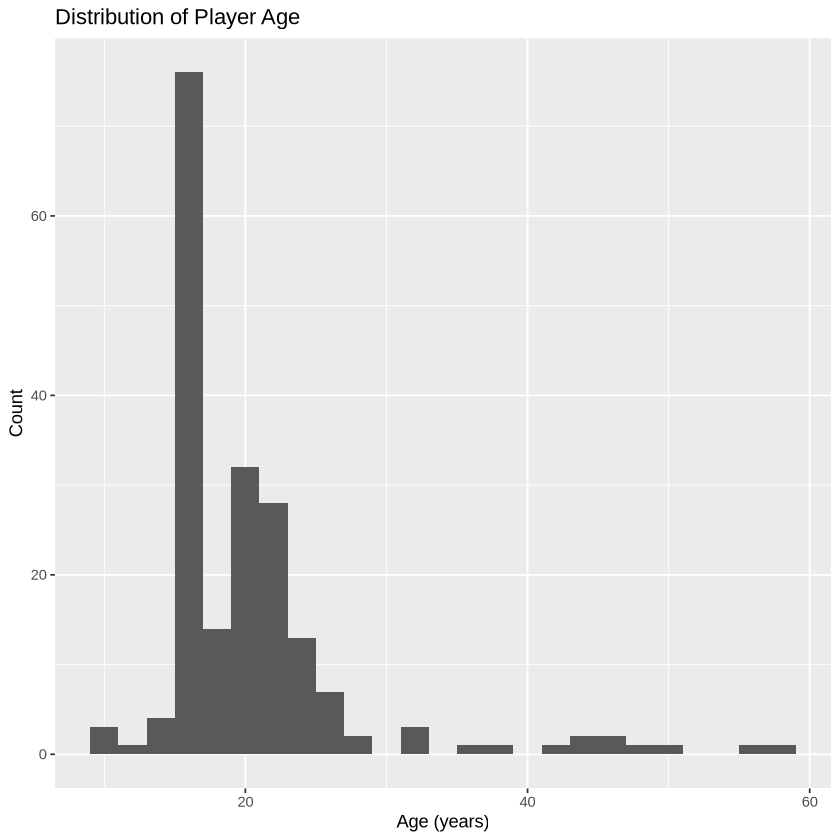

In [11]:
ggplot(players, aes(age)) +
  geom_histogram(binwidth = 2) +
  labs(title = "Distribution of Player Age",
       x = "Age (years)", y = "Count")


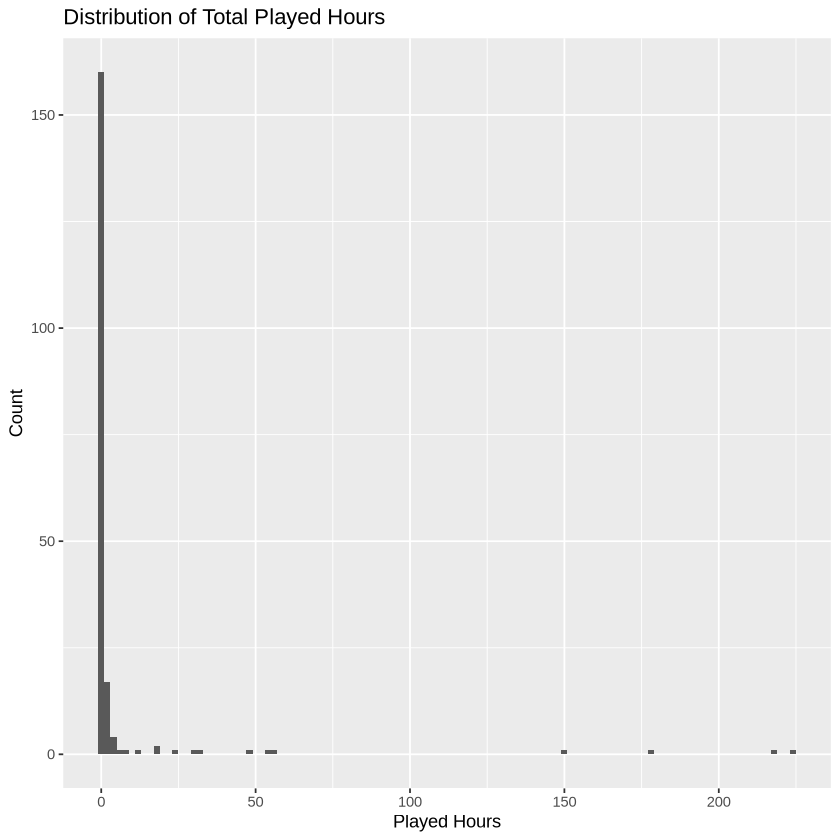

In [12]:
ggplot(players, aes(played_hours)) +
  geom_histogram(binwidth = 2) +
  labs(title = "Distribution of Total Played Hours",
       x = "Played Hours", y = "Count")


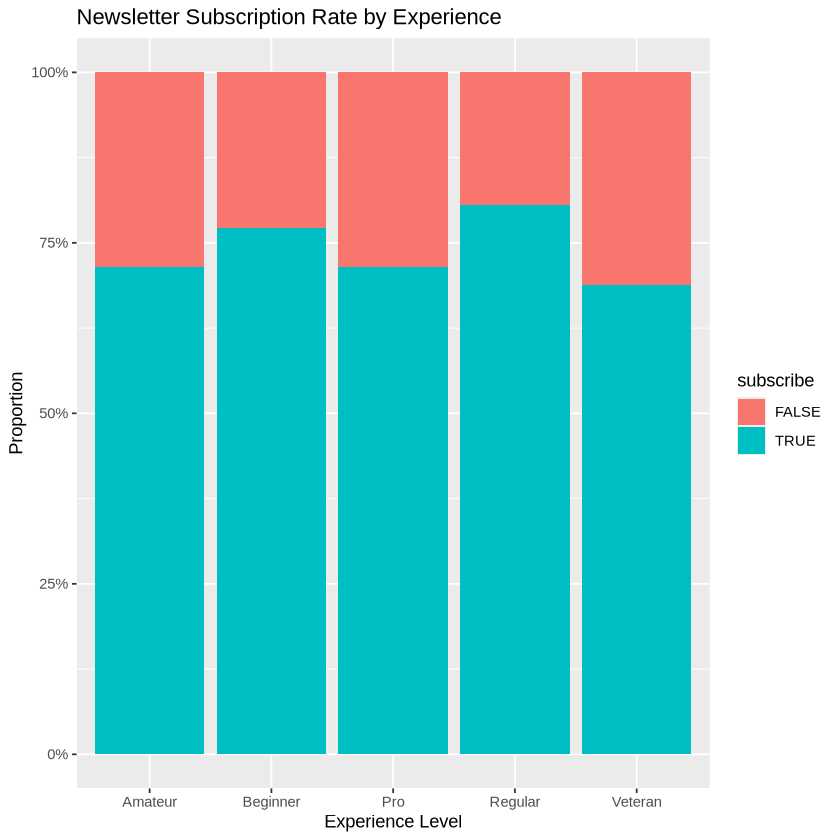

In [13]:
ggplot(players, aes(experience, fill = subscribe)) +
  geom_bar(position = "fill") +
  scale_y_continuous(labels = scales::percent) +
  labs(title = "Newsletter Subscription Rate by Experience",
       x = "Experience Level", y = "Proportion")


In [19]:
sessions_fixed <- sessions |>
  mutate(
    start = as.POSIXct(original_start_time / 1000, origin = "1970-01-01"),
    date = as.Date(start)
  )

sessions_by_day <- sessions_fixed |>
  count(date, name = "sessions")

sessions_by_day



date,sessions
<date>,<int>
2024-04-06,4
2024-04-07,4
2024-04-08,4
2024-04-09,1
2024-04-14,2
2024-04-15,8
2024-04-16,8
2024-04-17,10
2024-04-18,14


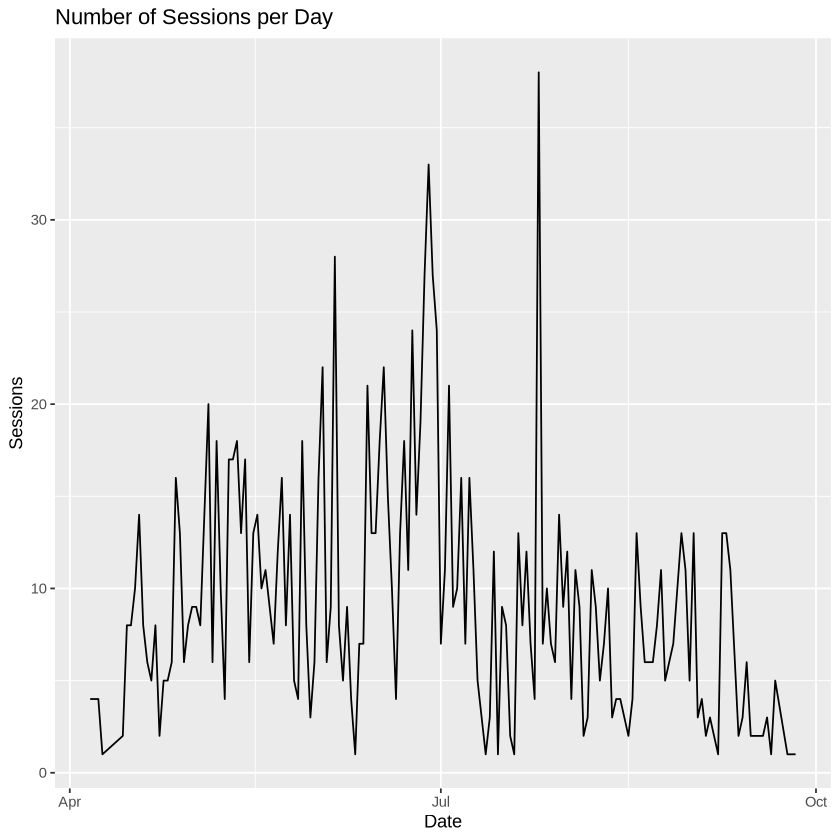

In [20]:
ggplot(sessions_by_day, aes(date, sessions)) +
  geom_line() +
  labs(title = "Number of Sessions per Day",
       x = "Date", y = "Sessions")


(4) Methods and Plan

Method chosen: Logistic regression

• Why is this method appropriate?

Logistic regression is appropriate because the response variable, subscribe, is binary (TRUE/FALSE). The method directly models the probability of subscription and allows clear interpretation of how each predictor affects the outcome.

• Which assumptions are required to apply this method?

The main assumptions are that observations are independent, and that the predictors have an approximately linear relationship with the log-odds of the response. Logistic regression also assumes no perfect multicollinearity among predictors.

• What are the potential limitations or weaknesses of this method?

Logistic regression may not capture nonlinear patterns or complex interactions unless explicitly added. It can also be sensitive to outliers in numeric predictors such as played_hours. If the true relationship is highly nonlinear, the model may underperform.

• How are you going to compare and select the model?

I will compare models using accuracy, confusion matrices, and possibly ROC-based metrics. Different sets of predictors may be tested, and the best-performing model on the test set will be selected.

• How are you going to process the data to apply the model?

I will split the data into training and testing sets, using an 80/20 split. All wrangling and feature creation will be completed before splitting. The model will be trained on the training set and evaluated on the test set. Cross-validation may be used later if needed during the final project phase.

(5) GitHub Repository  